# How many racks overlap?

In [12]:
import geojson
import geopandas
import pandas as pd
from sklearn.cluster import DBSCAN
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

import overpass
from shapely import Polygon

In [13]:
with open("../Output Files/bicycle-parking-high-capacity-outdoor-normalized.geojson") as f:
  city_highcap_gj = geojson.load(f)

city_highcap = geopandas.GeoDataFrame.from_features(
  city_highcap_gj,
  crs=4326
)

with open("../Output Files/bicycle-parking-racks-normalized.geojson") as f:
  city_racks_gj = geojson.load(f)

city_racks = geopandas.GeoDataFrame.from_features(
  city_racks_gj,
  crs=4326
)

with open("../Output Files/street-furniture-bicycle-parking-normalized.geojson") as f:
  city_furniture_gj = geojson.load(f)

city_furniture = geopandas.GeoDataFrame.from_features(
  city_furniture_gj,
  crs=4326
)

# explode
city_highcap = city_highcap.explode(index_parts=False)
city_racks = city_racks.explode(index_parts=False)
city_furniture = city_furniture.explode(index_parts=False)

# filter
city_highcap = city_highcap[city_highcap['bicycle_parking'] == "rack"]
city_furniture = city_furniture[city_furniture['bicycle_parking'] == "rack"]

# add source field
city_highcap.insert(0, 'source', "bicycle-parking-high-capacity-outdoor")
city_racks.insert(0, 'source', "bicycle-parking-racks")
city_furniture.insert(0, 'source', "street-furniture-bicycle-parking")

# combine and keep duplicates
all_combined = pd.concat([city_highcap, city_racks, city_furniture])
duplicate_racks = all_combined[all_combined['geometry'].duplicated(keep=False)]

# combine and drop duplicates
city_combined = pd.concat([city_highcap, city_racks, city_furniture])
city_combined = city_combined.drop_duplicates('geometry')

## All Racks

In [14]:
m_all = all_combined.explore('source', cmap=['blue', 'red', 'green'], marker_kwds={'radius': 10}, style_kwds={'weight': 5})
# dir(m_all)

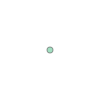

In [15]:
duplicate_racks.iloc[1]['geometry']

## Exact Duplicate GeoLocation Racks

In [28]:
# get boundary for Toronto Metropolitan University
api = overpass.API()
response = api.get("way(id:23250594)", responseformat="geojson", verbosity="geom")
tmupoly = Polygon(response['features'][0]['geometry']['coordinates'])
mtmu = geopandas.GeoSeries(tmupoly, crs=4326).buffer(0.0002).explore()

/var/folders/nb/0tm6c0md4szcl32rp0x_70s40000gn/T/ipykernel_65352/1673134257.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mtmu = geopandas.GeoSeries(tmupoly, crs=4326).buffer(0.0002).explore()


In [ ]:
# duplicate_racks.explore('source', cmap=['blue', 'red', 'green'], marker_kwds={'radius': 10}, style_kwds={'weight': 5})

dupe_item = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(duplicate_racks['geometry'].unique()) - 1,
    step=1,
    description='Item:',
    disabled=False
)

m0 = all_combined.explore('source', m=mtmu, cmap=['blue', 'red', 'green'], marker_kwds={'radius': 10}, style_kwds={'weight': 5})

groups = duplicate_racks['geometry'].unique()

group = None
def on_value_change(change):
    group = duplicate_racks[duplicate_racks['geometry'] == groups[dupe_item.value]]
    bounds = group.total_bounds.tolist()
    m = group.explore('source', cmap=['purple', 'orange', 'darkgreen'], marker_kwds={'radius': 10}, style_kwds={'weight': 5})
    clear_output(wait=True)
    url = f"https://www.google.com/maps/@{groups[dupe_item.value].y},{groups[dupe_item.value].x},18z"
    display(dupe_item, url, m, group.transpose(), m0)
    # for row in group.iterrows():
    #     display(row)

dupe_item.observe(on_value_change)
on_value_change(None)

BoundedIntText(value=1, description='Item:', max=101)

'https://www.google.com/maps/@43.662057,-79.427871,18z'

,1,2,84,128
source,bicycle-parking-high-capacity-outdoor,bicycle-parking-high-capacity-outdoor,bicycle-parking-racks,bicycle-parking-racks
amenity,bicycle_parking,bicycle_parking,bicycle_parking,bicycle_parking
bicycle_parking,rack,rack,rack,rack
capacity,5.0,8.0,5.0,8.0
operator,City of Toronto,City of Toronto,City of Toronto,City of Toronto
covered,None,None,no,no
access,yes,yes,yes,yes
fee,no,no,no,no
start_date,2014.0,2014.0,NaN,NaN
length,2.9,3.0,NaN,NaN


In [31]:
city_combined_UTM17N = city_combined.to_crs(32617)

# cluster points
coordinates = city_combined_UTM17N["geometry"].get_coordinates().values
clusters = DBSCAN(eps=30.0, min_samples=2).fit(coordinates)
city_combined_UTM17N = city_combined_UTM17N.assign(cluster=clusters.labels_)

# remove non-clustered points
city_combined_UTM17N = city_combined_UTM17N[city_combined_UTM17N['cluster'] >= 0]

# remove clusters with only one data source
sources_per_cluster = dict(city_combined_UTM17N[['cluster', 'source']].groupby('cluster')['source'].unique().apply(lambda r: len(r)))
sources_per_cluster_test = city_combined_UTM17N['cluster'].apply(lambda c: sources_per_cluster[c] > 1)
city_combined_UTM17N = city_combined_UTM17N[sources_per_cluster_test]

## Close Proximity Racks

In [ ]:
item = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(city_combined_UTM17N['cluster'].unique()) - 1,
    step=1,
    description='Item:',
    disabled=False
)

clusters = city_combined_UTM17N['cluster'].unique()

unit = None
def on_value_change(change):
    unit = city_combined_UTM17N[city_combined_UTM17N['cluster'] == clusters[item.value]]
    m = unit.explore('source', cmap=['blue', 'red', 'green'], marker_kwds={'radius': 10}, style_kwds={'weight': 5})
    clear_output(wait=True)
    display(item, m, unit.transpose())
    # for row in unit.iterrows():
    #     display(row)

item.observe(on_value_change)
on_value_change(None)


BoundedIntText(value=2, description='Item:', max=14)

,23,9543
source,bicycle-parking-high-capacity-outdoor,street-furniture-bicycle-parking
amenity,bicycle_parking,bicycle_parking
bicycle_parking,rack,rack
capacity,14.0,NaN
operator,City of Toronto,City of Toronto
covered,None,no
access,yes,yes
fee,no,no
start_date,2015.0,NaN
length,5.5,NaN


In [53]:
city_combined_UTM17N.explore()